In [1]:
pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.6/612.6 kB 12.5 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


**В данном нотбуке я покажу, как решить задачу детектирования сорняков для агрокультурного сектора с помощью SOTA модели YOLOv8x**

In [2]:
import pandas as pd
import numpy as np
from ultralytics import YOLO
import torch

import shutil
import os

import random

from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Data preparation

В качестве данных для обучения взял 2 датасета [WeedCrop Image Dataset](https://www.kaggle.com/datasets/vinayakshanawad/weedcrop-image-dataset) 2822 изображений различного качества и [LincoInBeet](https://datasets.activeloop.ai/docs/ml/datasets/lincolnbeet-dataset/#lincoinbeet-dataset) 4402 высокачественных изображений размером 1920 x 1080 пискелей. 

В сумме у нас получается 7224 изображений, разделим их в соотношении 5558:676:990 соответственно train:val:test.

Но для начала и нужно датасеты собрать и структурировать.

In [3]:
source_folder = "/kaggle/input/weedcrop-image-dataset/WeedCrop.v1i.yolov5pytorch"

# Папка test
test_source_images = os.path.join(source_folder, "test/images")
test_source_labels = os.path.join(source_folder, "test/labels")

test_destination_folder = "/kaggle/working/test"
os.makedirs(test_destination_folder, exist_ok=True)

# Перемещение изображений
shutil.copytree(test_source_images, os.path.join(test_destination_folder, "images"))

# Перемещение меток
shutil.copytree(test_source_labels, os.path.join(test_destination_folder, "labels"))


# Папка train
train_source_images = os.path.join(source_folder, "train/images")
train_source_labels = os.path.join(source_folder, "train/labels")

train_destination_folder = "/kaggle/working/train"
os.makedirs(train_destination_folder, exist_ok=True)

# Перемещение изображений
shutil.copytree(train_source_images, os.path.join(train_destination_folder, "images"))

# Перемещение меток
shutil.copytree(train_source_labels, os.path.join(train_destination_folder, "labels"))


# Папка valid
valid_source_images = os.path.join(source_folder, "valid/images")
valid_source_labels = os.path.join(source_folder, "valid/labels")

valid_destination_folder = "/kaggle/working/valid"
os.makedirs(valid_destination_folder, exist_ok=True)

# Перемещение изображений
shutil.copytree(valid_source_images, os.path.join(valid_destination_folder, "images"))

# Перемещение меток
shutil.copytree(valid_source_labels, os.path.join(valid_destination_folder, "labels"))

'/kaggle/working/valid/labels'

In [4]:
def move_files(file_path, source_folder, destination_folder):
    # Чтение списка названий файлов
    with open(file_path, "r") as file:
        file_names = [os.path.basename(line.strip()) for line in file.readlines()]

    # Папки для изображений и меток
    images_folder = os.path.join(destination_folder, "images")
    labels_folder = os.path.join(destination_folder, "labels")
    
    # Перемещение файлов
    for file_name in file_names:
        image_file = os.path.join(source_folder, file_name)
        label_file = os.path.join(source_folder, file_name.replace(".png", ".txt"))
        if os.path.isfile(image_file):
            shutil.copy(image_file, images_folder)
        if os.path.isfile(label_file):
            shutil.copy(label_file, labels_folder)

In [5]:
train_file = "/kaggle/input/amiran/all_fields_lincolnbeet/all_fields_lincolnbeet_train_.txt"
valid_file = "/kaggle/input/amiran/all_fields_lincolnbeet/all_fields_lincolnbeet_val_.txt"
test_file = "/kaggle/input/amiran/all_fields_lincolnbeet/all_fields_lincolnbeet_test_.txt"

source_folder = "/kaggle/input/amiran/all_fields_lincolnbeet/all"
train_destination = "/kaggle/working/train"
valid_destination = "/kaggle/working/valid"
test_destination = "/kaggle/working/test"

move_files(train_file, source_folder, train_destination)
move_files(valid_file, source_folder, valid_destination)
move_files(test_file, source_folder, test_destination)

In [6]:
# Создадим yaml для YOLO
import  yaml

# Data structure
dataset = {
'train': '/kaggle/working/train',
'val': '/kaggle/working/valid',
'test': '/kaggle/working/test',
'nc': 2,
'names': ['crop', 'weed']
}

# save to YAML-file
with open('/kaggle/working/dataset.yaml', 'w') as file:
    yaml.dump(dataset, file)

In [7]:
ls /kaggle/working

__notebook_source__.ipynb  dataset.yaml  test/  train/  valid/


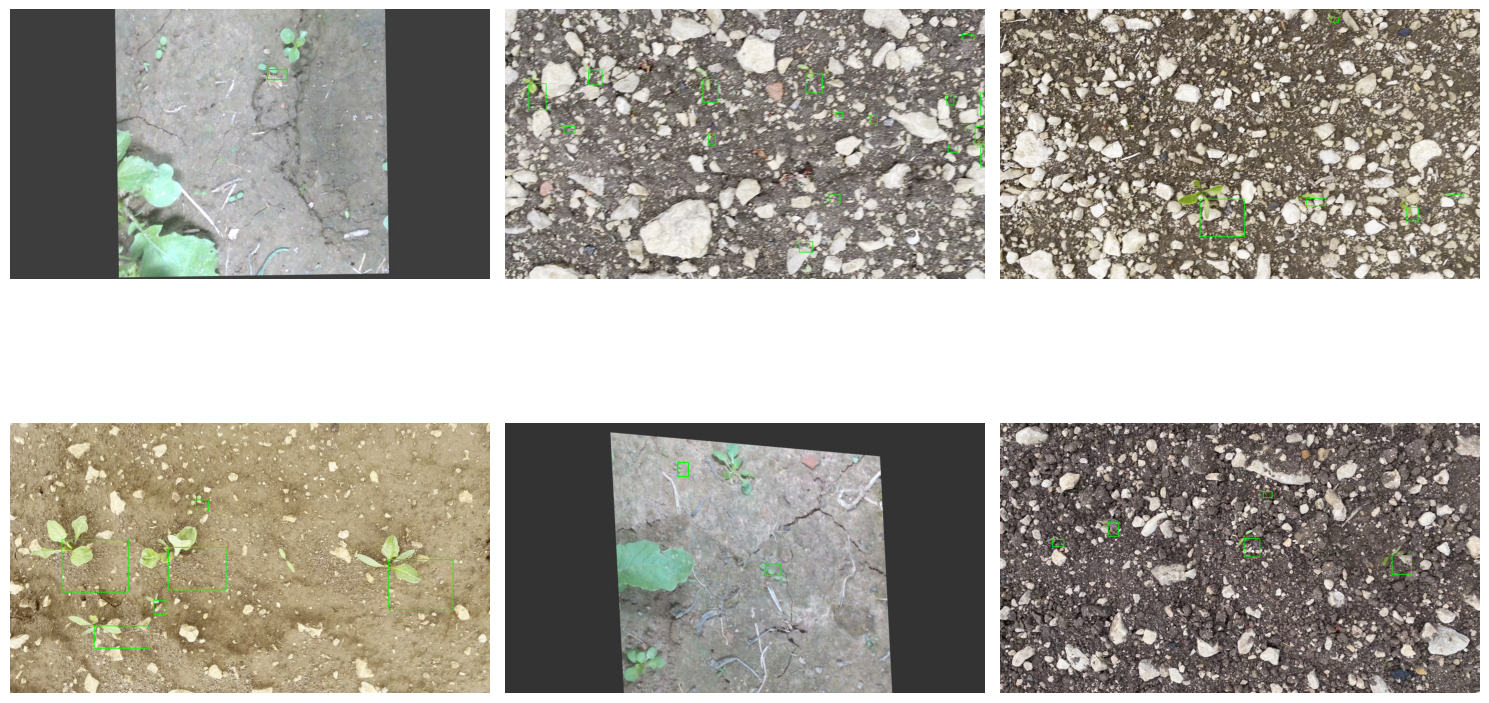

In [8]:
# Папки с изображениями и метками
images_folder = "/kaggle/working/train/images"
labels_folder = "/kaggle/working/train/labels"

# Загрузка списка файлов изображений
image_files = os.listdir(images_folder)

# Выбор случайных изображений
random.shuffle(image_files)
random_image_files = image_files[:6]

# Отображение случайных изображений с метками
num_images = len(random_image_files)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(num_images):
    # Загрузка изображения
    image_file = os.path.join(images_folder, random_image_files[i])
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Загрузка меток из файла
    label_file = os.path.join(labels_folder, os.path.splitext(random_image_files[i])[0] + ".txt")
    with open(label_file, "r") as file:
        labels = file.readlines()

    # Отображение изображения с метками
    for label in labels:
        class_id, x, y, width, height = map(float, label.strip().split())
        x = int(x * image.shape[1])
        y = int(y * image.shape[0])
        width = int(width * image.shape[1])
        height = int(height * image.shape[0])
        cv2.rectangle(image, (x, y), (x + width, y + height), (0, 255, 0), 2)

    # Отображение изображения
    axes[i].imshow(image)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

# Train loop

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [10]:
model = YOLO('yolov8x.pt')

100%|██████████| 131M/131M [00:02<00:00, 63.3MB/s] 


In [11]:
model.train(data='/kaggle/working/dataset.yaml ', epochs=50, imgsz=640,
            optimizer = 'AdamW', lr0 = 1e-3, 
            project = 'TG_YOLOv8x', name='Didi',
            batch=16, device=device, seed=69)

Ultralytics YOLOv8.0.124 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/kaggle/working/dataset.yaml , epochs=50, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=TG_YOLOv8x, name=Didi, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=69, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, in

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
100%|██████████| 6.23M/6.23M [00:00<00:00, 113MB/s]
AMP: checks passed ✅
train: Scanning /kaggle/working/train/labels... 5550 images, 109 backgrounds, 0 corrupt: 100%|██████████| 5558/5558 [01:10<00:00, 78.80it/s] 
train: WARNING ⚠️ /kaggle/working/train/images/near30_near30_01_06_2021_v_0_63.png: 1 duplicate labels removed
train: New cache created: /kaggle/working/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
val: Scanning /kaggle/working/valid/labels... 675 images, 1 backgrounds, 0 corrupt: 100%|██████████| 676/676 [00:09<00:00, 70.83it/s] 
val: New cache created: /kaggle/working/valid/labels.cache
Plotting labels to TG_YOLOv8x/Didi/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image 

Последние 10 эпох мы уперлись в потолок mAP 0.796

# Train metrics and losses

Yolo очень удобный фрэймворк, который сохраняте логи и также готовые графики метрик и лосов.
Не будем придумывать велосипед и воспользуемся готовым решением.

In [13]:
df = pd.read_csv('/kaggle/working/TG_YOLOv8x/Didi/results.csv')

In [14]:
df.columns

Index(['                  epoch', '         train/box_loss',
       '         train/cls_loss', '         train/dfl_loss',
       '   metrics/precision(B)', '      metrics/recall(B)',
       '       metrics/mAP50(B)', '    metrics/mAP50-95(B)',
       '           val/box_loss', '           val/cls_loss',
       '           val/dfl_loss', '                 lr/pg0',
       '                 lr/pg1', '                 lr/pg2'],
      dtype='object')

Loss

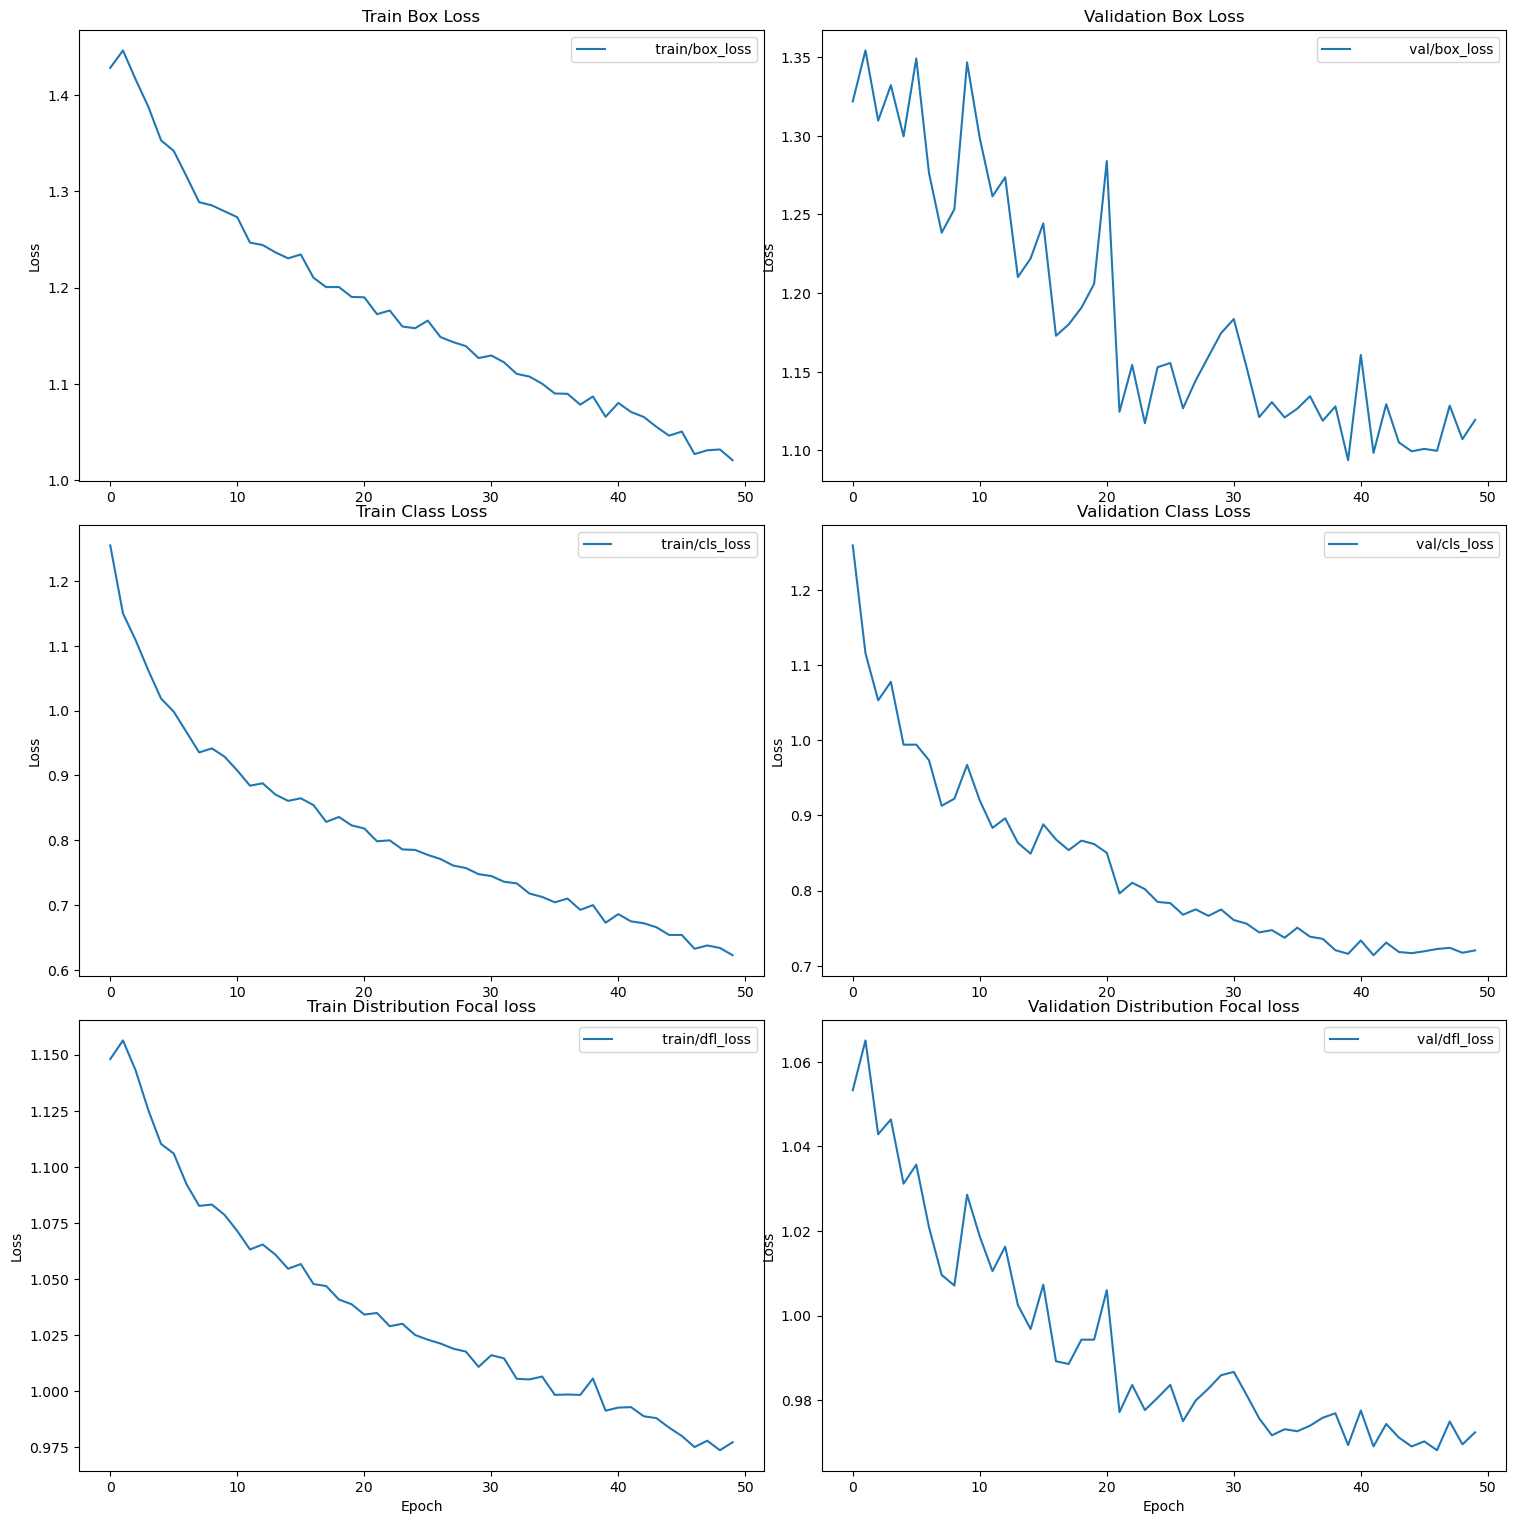

In [15]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.tight_layout()

# train/box_loss
axes[0, 0].plot(df['                  epoch'], df['         train/box_loss'], label='         train/box_loss')
axes[0, 0].set_title('Train Box Loss')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# val/box_loss
axes[0, 1].plot(df['                  epoch'], df['           val/box_loss'], label='           val/box_loss')
axes[0, 1].set_title('Validation Box Loss')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()

# train/cls_loss
axes[1, 0].plot(df['                  epoch'], df['         train/cls_loss'], label='         train/cls_loss')
axes[1, 0].set_title('Train Class Loss')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()

# val/cls_loss
axes[1, 1].plot(df['                  epoch'], df['           val/cls_loss'], label='           val/cls_loss')
axes[1, 1].set_title('Validation Class Loss')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()

# train/dfl_loss
axes[2, 0].plot(df['                  epoch'], df['         train/dfl_loss'], label='         train/dfl_loss')
axes[2, 0].set_title('Train Distribution Focal loss')
axes[2, 0].set_xlabel('Epoch')
axes[2, 0].set_ylabel('Loss')
axes[2, 0].legend()

# val/dfl_loss
axes[2, 1].plot(df['                  epoch'], df['           val/dfl_loss'], label='           val/dfl_loss')
axes[2, 1].set_title('Validation Distribution Focal loss')
axes[2, 1].set_xlabel('Epoch')
axes[2, 1].set_ylabel('Loss')
axes[2, 1].legend()

plt.show()

Metrics на обучении

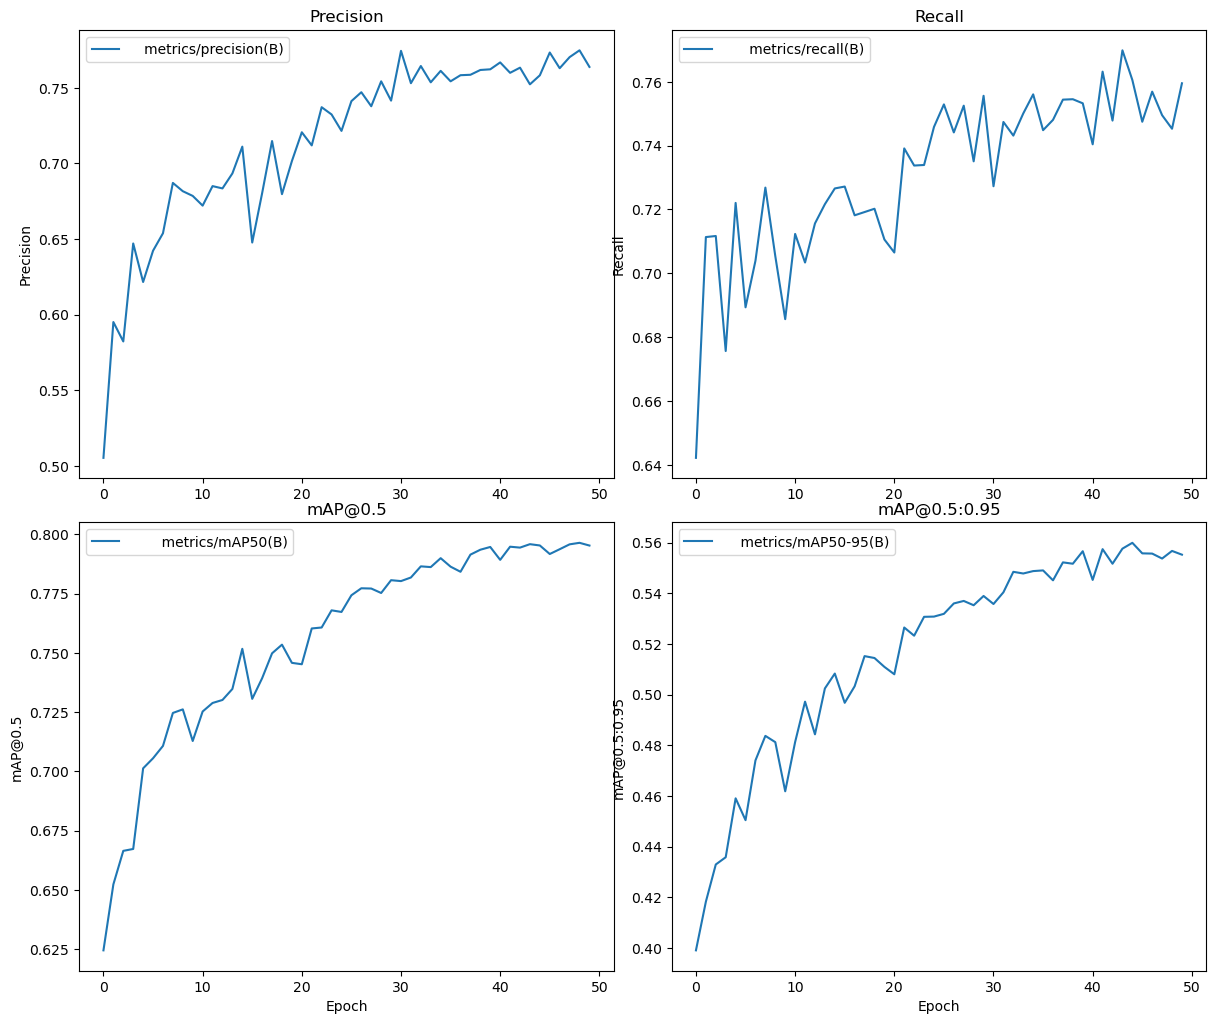

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.tight_layout()

# metrics/precision(B)
axes[0, 0].plot(df['                  epoch'], df['   metrics/precision(B)'], label='   metrics/precision(B)')
axes[0, 0].set_title('Precision')
axes[0, 0].set_ylabel('Precision')
axes[0, 0].legend()

# metrics/recall(B)
axes[0, 1].plot(df['                  epoch'], df['      metrics/recall(B)'], label='      metrics/recall(B)')
axes[0, 1].set_title('Recall')
axes[0, 1].set_ylabel('Recall')
axes[0, 1].legend()

# График для metrics/mAP50(B)
axes[1, 0].plot(df['                  epoch'], df['       metrics/mAP50(B)'], label='       metrics/mAP50(B)')
axes[1, 0].set_title('mAP@0.5')
axes[1, 0].set_ylabel('mAP@0.5')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].legend()

# metrics/mAP50-95(B)
axes[1, 1].plot(df['                  epoch'], df['    metrics/mAP50-95(B)'], label='    metrics/mAP50-95(B)')
axes[1, 1].set_title('mAP@0.5:0.95')
axes[1, 1].set_ylabel('mAP@0.5:0.95')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].legend()

plt.show()

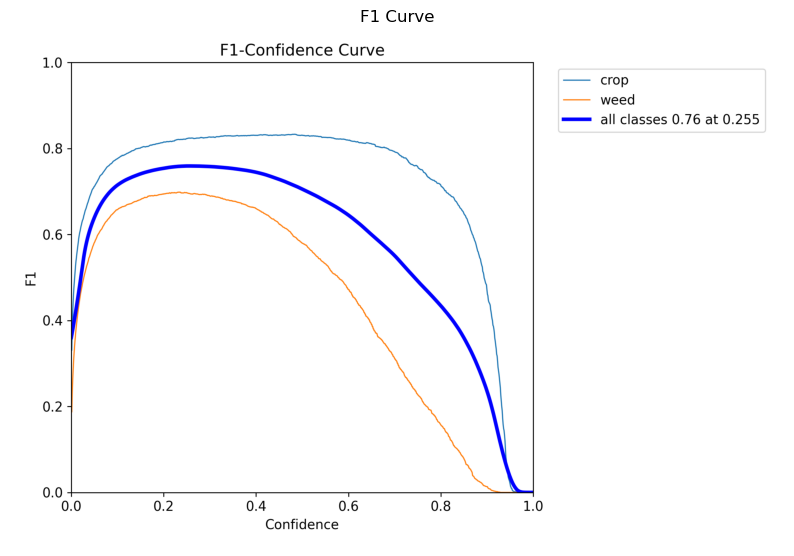

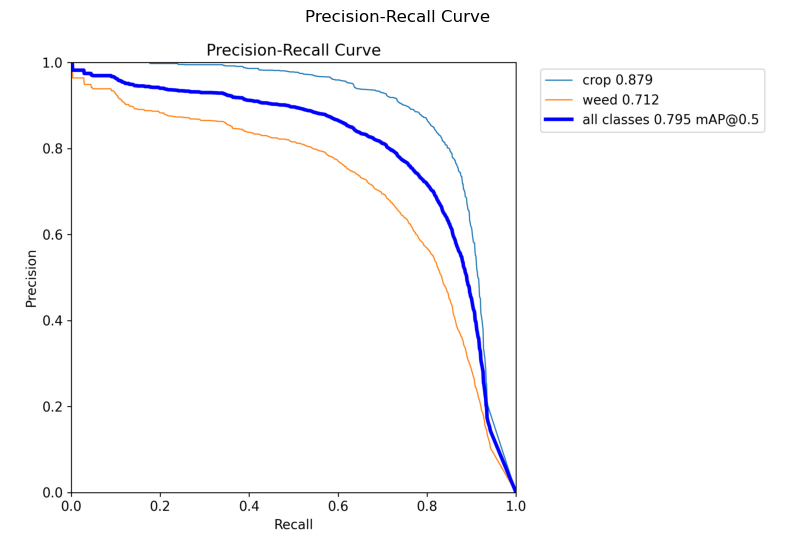

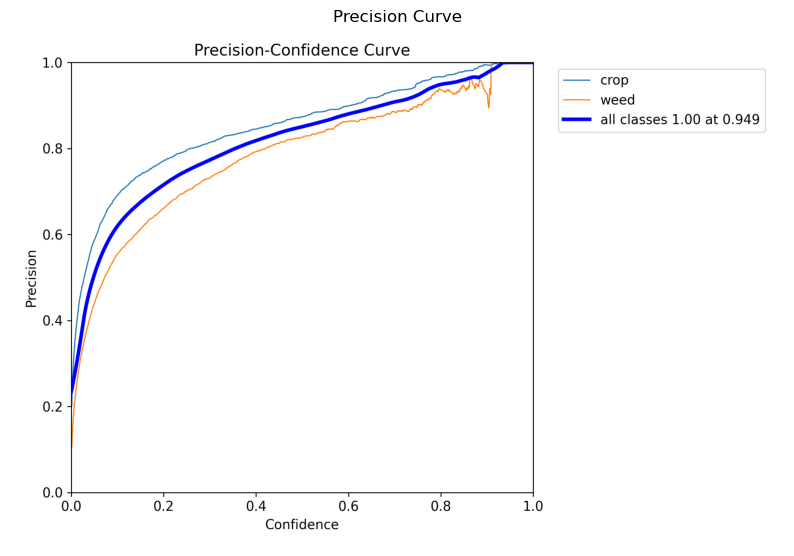

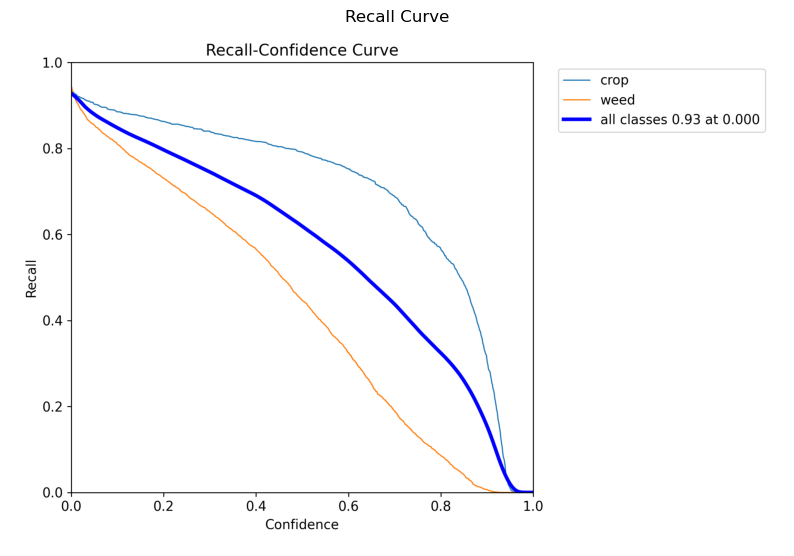

In [19]:
# F1_curve.png
f1_curve = Image.open("/kaggle/working/TG_YOLOv8x/Didi/F1_curve.png")
plt.figure(figsize=(10, 10))
plt.imshow(f1_curve)
plt.title("F1 Curve")
plt.axis("off")
plt.show()

# PR_curve.png
pr_curve = Image.open("/kaggle/working/TG_YOLOv8x/Didi/PR_curve.png")
plt.figure(figsize=(10, 10))
plt.imshow(pr_curve)
plt.title("Precision-Recall Curve")
plt.axis("off")
plt.show()

# P_curve.png
p_curve = Image.open("/kaggle/working/TG_YOLOv8x/Didi/P_curve.png")
plt.figure(figsize=(10, 10))
plt.imshow(p_curve)
plt.title("Precision Curve")
plt.axis("off")
plt.show()

# R_curve.png
r_curve = Image.open("/kaggle/working/TG_YOLOv8x/Didi/R_curve.png")
plt.figure(figsize=(10, 10))
plt.imshow(r_curve)
plt.title("Recall Curve")
plt.axis("off")
plt.show()

Как видно по precision-recall curve графику, crop ,т.е. посевы имеют высокий процент детекции моделью, а вот с сорняками дела обстоят не так хорошо. Нужно больше данных с помеченными сорянками.

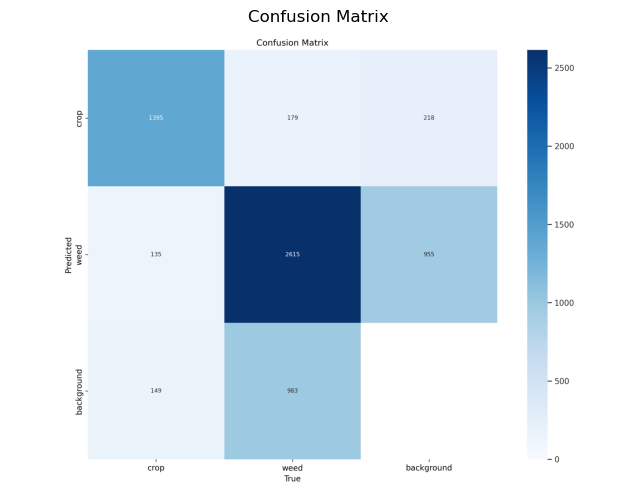

In [21]:
# confusion matrix
confusion_matrix = Image.open("/kaggle/working/TG_YOLOv8x/Didi/confusion_matrix.png")
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix)
plt.title("Confusion Matrix")
plt.axis("off")
plt.show()

Наибольшее количество ошибок нашей модели было связано с неправильной классификацией объектов как "background", в то время как на самом деле они были сорняками - 903 таких ошибок.И наоборот,  произошло 955 ошибок, когда модель классифицировала сорняки как "background".

В остальных случаях количество ошибок было незначительным, в районе значений 100-200.

# Evaluation 

Посмотрим как модель детектирует на тестовом наборе


image 1/1 /kaggle/working/test/images/bbro_bbro_14_05_2021_v_0_18.png: 384x640 4 crops, 26.6ms
Speed: 2.3ms preprocess, 26.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


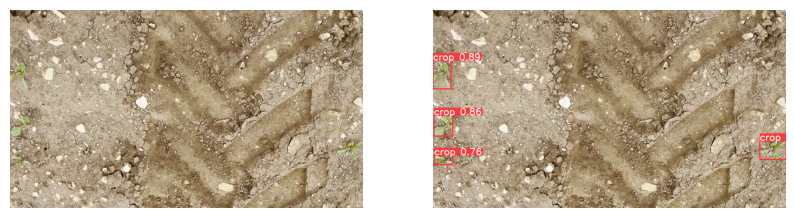

In [29]:
res = model('/kaggle/working/test/images/bbro_bbro_14_05_2021_v_0_18.png')
detect_img = res[0].plot()
detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Отображение первого изображения
axes[0].imshow(plt.imread('/kaggle/working/test/images/bbro_bbro_14_05_2021_v_0_18.png'))
axes[0].axis('off')

# Отображение результатов модели
axes[1].imshow(detect_img)
axes[1].axis('off')

plt.show();

Сохраним веса модели на обучении

In [24]:
model = YOLO('TG_YOLOv8x/Didi/weights/best.pt ')

In [25]:
metrics = model.val(split='test', conf=0.25, device=device) # conf - это порог достоверности объекта для обнаружения

Ultralytics YOLOv8.0.124 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
Model summary (fused): 268 layers, 68125494 parameters, 0 gradients
val: Scanning /kaggle/working/test/labels... 999 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1001/1001 [00:19<00:00, 51.99it/s]
val: New cache created: /kaggle/working/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [01:11<00:00,  1.14s/it]
                   all       1001       8605      0.747      0.743      0.778      0.592
                  crop       1001       3354      0.798      0.834      0.877      0.748
                  weed       1001       5251      0.695      0.652      0.678      0.436
Speed: 0.5ms preprocess, 15.8ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/val


In [26]:
metrics

ultralytics.yolo.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.yolo.utils.metrics.Metric object
confusion_matrix: <ultralytics.yolo.utils.metrics.ConfusionMatrix object at 0x7ea5aae43850>
fitness: 0.6106944667755827
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([      0.748,     0.43626])
names: {0: 'crop', 1: 'weed'}
plot: True
results_dict: {'metrics/precision(B)': 0.7466033572613735, 'metrics/recall(B)': 0.743093174631132, 'metrics/mAP50(B)': 0.7778147829897214, 'metrics/mAP50-95(B)': 0.5921255427517894, 'fitness': 0.6106944667755827}
save_dir: PosixPath('runs/detect/val')
speed: {'preprocess': 0.4526470805500652, 'inference': 15.82447298756846, 'loss': 0.001702037129130635, 'postprocess': 1.8442427361761773}

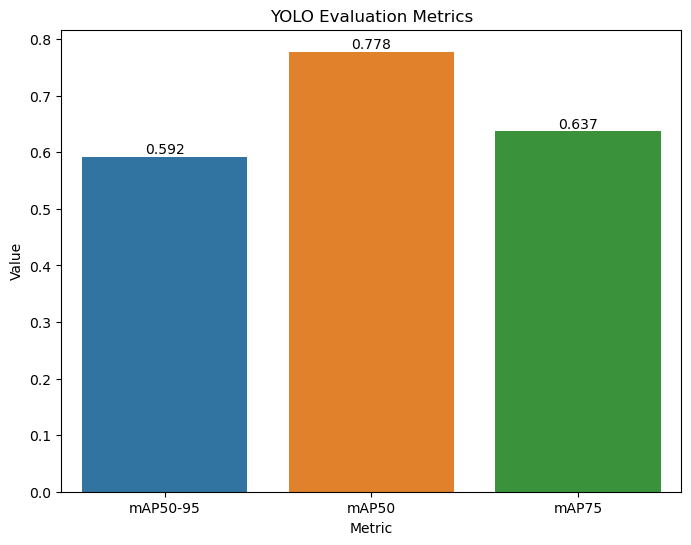

In [30]:
ax = sns.barplot(x=['mAP50-95', 'mAP50', 'mAP75'], y=[metrics.box.map, metrics.box.map50, metrics.box.map75])


ax.set_title('YOLO Evaluation Metrics')
ax.set_xlabel('Metric')
ax.set_ylabel('Value')


fig = plt.gcf()
fig.set_size_inches(8, 6)

for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
    

plt.show()

Таким образом, модель демонстрирует более высокую точность в обнаружении объектов при более низких порогах уверенности, а при более высоких порогах её точность снижается. Это может быть связано с тем, что при высоких порогах уверенности модель становится более консервативной и пропускает некоторые объекты, чтобы снизить вероятность ложных срабатываний.

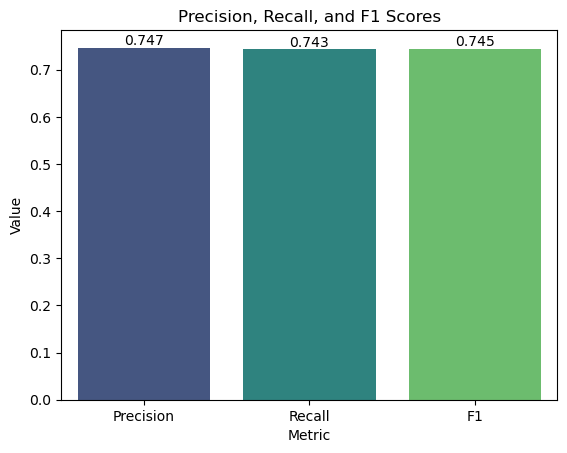

In [31]:
# Извлечение значений Precision, Recall и F1
precision = metrics.results_dict['metrics/precision(B)']
recall = metrics.results_dict['metrics/recall(B)']
f1 = (2 * precision * recall) / (precision + recall)  # Вычисление F1


metrics = ['Precision', 'Recall', 'F1']
values = [precision, recall, f1]

# Создание графика с использованием sns.barplot
ax = sns.barplot(x=metrics, y=values, palette='viridis')

ax.set_title('Precision, Recall, and F1 Scores')
ax.set_xlabel('Metric')
ax.set_ylabel('Value')

for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.show()

Как можно убедиться из метрик, 'Precision' модели очень даже неплохая, она распознает хорошо оба класса и находит их с примерно с одинаковым показателем.

Взглянем на 10 случайных изображений 

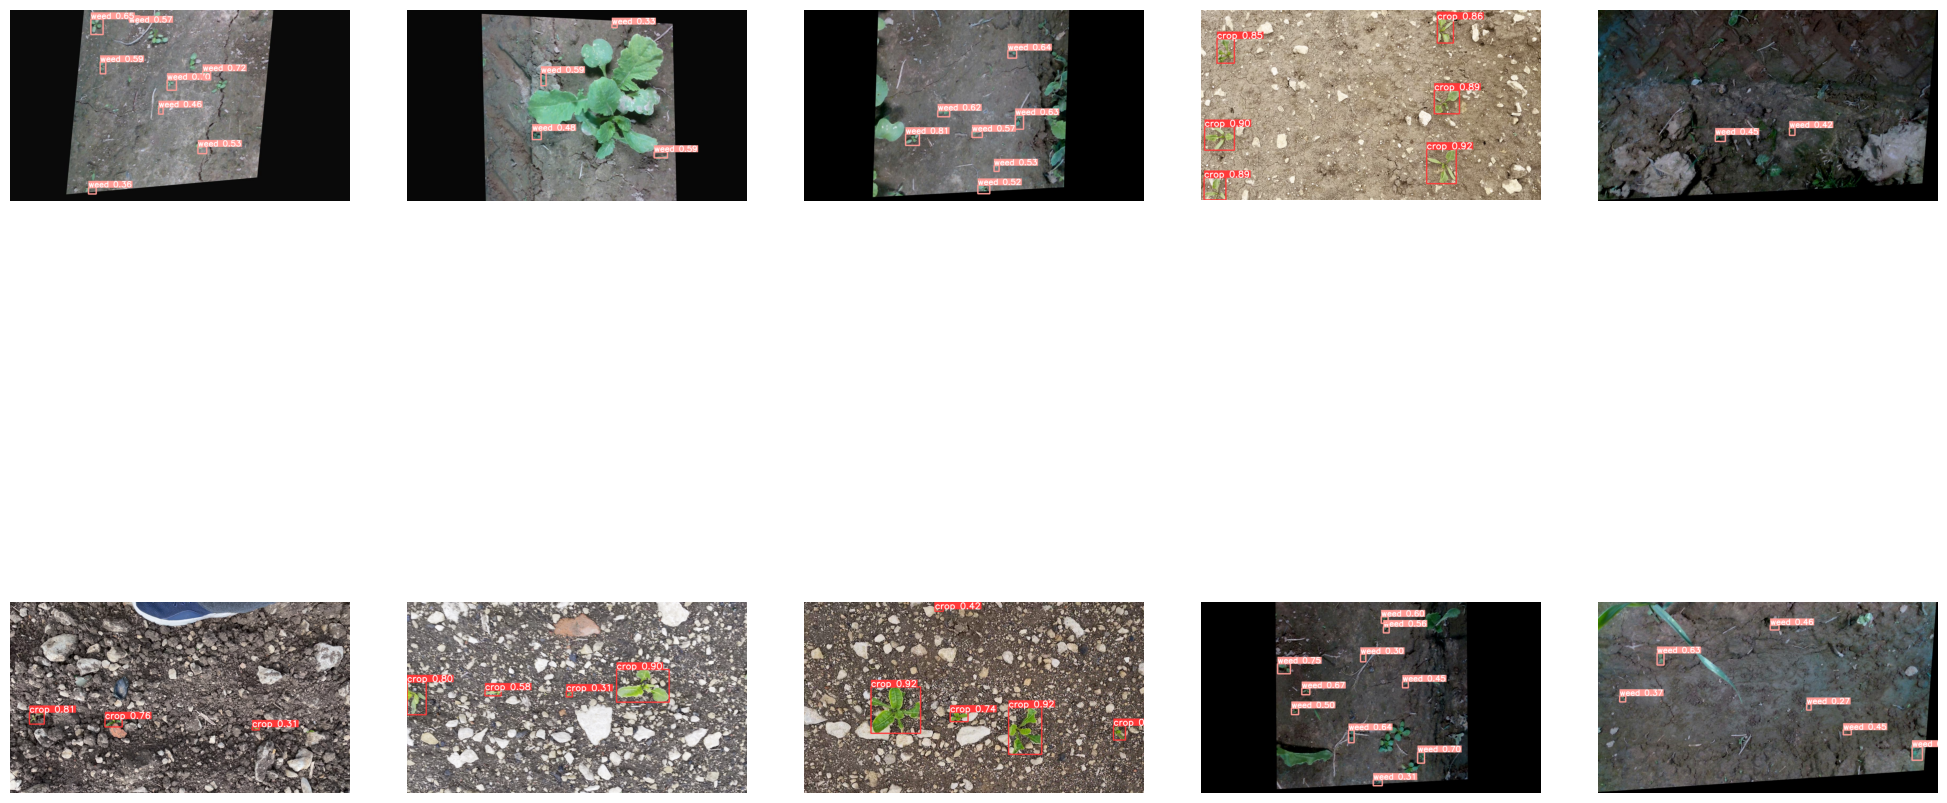

In [32]:
# Получение случайных изображений
image_paths = random.sample(os.listdir(images_folder), 10)

# Создание фигуры с подокнами и увеличенным размером фотографий
fig, axes = plt.subplots(2, 5, figsize=(20, 12))
fig.tight_layout()

# Итерация по каждому подокну
for i, ax in enumerate(axes.flat):
    image_path = os.path.join(images_folder, image_paths[i])
    image = Image.open(image_path)
    res = model(image, verbose=False)
    detect_img = res[0].plot()
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)
    
    ax.imshow(detect_img)
    ax.axis('off')
    
plt.show()

# Вывод


В этом ноутбуке мы обучили модель YOLOv8x на объединенных данных, изучили метрики и потери в процессе обучения, а также проанализировали вывод модели на нескольких изображениях и качество детекции на тестовых данных.

Для достижения более высоких показателей модели и успешного применения ее в бизнес-процессах рекомендуется провести более тщательные исследования. Вот некоторые шаги, которые могут быть предприняты:

Собрать больше данных: Больший объем разнообразных данных поможет модели лучше обобщать и распознавать объекты. Можно провести сбор новых данных или найти доступные датасеты для дополнения текущего обучающего набора.

Настроить гиперпараметры: Подбор оптимальных гиперпараметров модели может значительно повлиять на ее производительность. Можно провести эксперименты с различными значениями гиперпараметров, такими как размеры якорей, пороги уверенности и другие, чтобы достичь лучших результатов.

Провести дополнительные эксперименты: Экспериментирование с различными архитектурами модели, вариациями YOLOv8 или других моделей детекции объектов, может привести к лучшим результатам. 

и т.д.

В целом, более точные исследования (в  частности нужно больше помеченных данных с метками и боксами сорняков), эксперименты и работа над улучшением модели позволят достичь более высоких показателей и повысить ее применимость в реальных бизнес-сценариях.
Конечно же все упирается в ресурсы, как вычислительные, так и денежные.